# Общие сведения

Далее рассматривается реализация Skip-gram подхода к задаче word2vec

In [ ]:
import numpy as np
import torch
import torch.nn as nn

import time

import gensim.downloader as api

Загрузим датасет text8 из gensim, данный датасет уже предобработан, что позволит нам не отвлекаться на препроцессинг.

In [ ]:
dataset = api.load("text8")
data = [d for d in dataset]
print(data[0][:30])

train_data = ' '.join(data[0])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


Относительно CBOW, вход и выход Skip-gram инвертированы, т.е. на основе слова необходимо предсказать слова, которые вероятнее всего встретятся как его контекст.

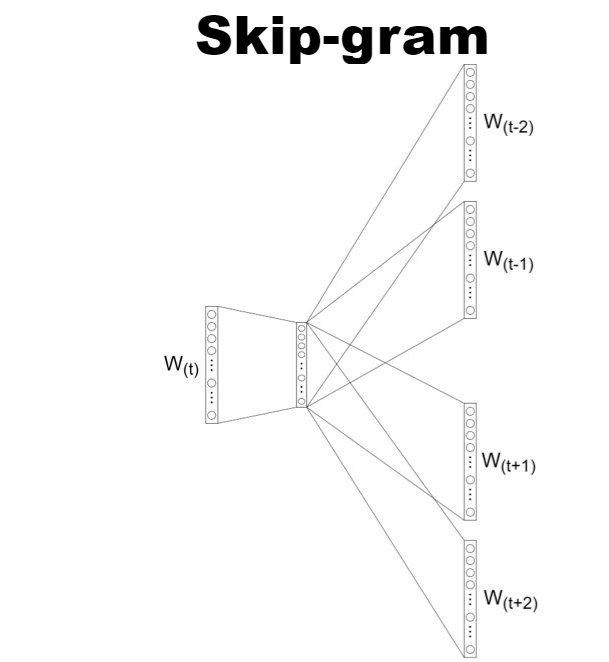

Как описано в оригинальной [статье](https://arxiv.org/abs/1301.3781). Размер контекста выбирается случайно от 1 до C (C - максимальный размер окна)

In [ ]:
splitted = train_data.split()
# составим список слов
vocabulary = np.asarray(list(set(splitted)))
# создадим словарь слово-индекс, для удобства
word2idx = {word: idx for (idx, word) in enumerate(vocabulary)}

window_size = 10
# слова, подаваемые на вход, совпадают с исходным текстом
words = splitted

В паре со Skip-gram часто упоминается техника negative sampling, которая предлагает вместо увеличения вероятности для слов из контекста, уменьшать вероятность для слов вне контекста, что во-первых все еще решает поставленную задачу, т.к. вероятности слов контекста все еще растут (из-за того что суммарная вероятность всгда равна 1), во-вторых позволяет сильно упростить вычисления, т.к. позволяет использовать сигмоиду вместо softmax и, следовательно, упростить вычисления.

Ниже представлен код для составления таргета в формате negative sampling.

In [ ]:
# составим контексты для каждого слова
true_contexts = [splitted[max(0,i-window_size):i]+splitted[i+1:min(len(splitted),i+1+window_size)] \
                      for i in range(len(splitted))]
# переведем контексты из слов в соответствующие индексы
true_contexts_idx = [[word2idx[word] for word in ar] for ar in true_contexts]

# составим вероятности встретить то или иное слово в таргете
# для слов из контекста - 0, для остальных - равная
probabilities = np.zeros((len(true_contexts), len(vocabulary)))
for i, context_idx in enumerate(true_contexts_idx):
    probabilities[i] = np.array([1/(len(vocabulary)-len(context_idx)) for i in vocabulary])
    probabilities[i, context_idx] = 0
    probabilities[i] /= probabilities[i].sum()
    probabilities[i, -1] = max(0, 1 - sum(probabilities[i, :-1]))

# составим по сути "анти-контексты" слов, контекстом назван для удобства
contexts = [vocabulary[np.random.choice(len(vocabulary), np.random.randint(1,window_size*2,1), p=probabilities[i])]
                                                                              for i in range(len(words))]

In [ ]:
probabilities[0, -1] = 1 - sum(probabilities[0, :-1])

Ниже представлена архитектура skip-gram модели. На вход подается слово, по нему выделяются эмбеддинги, проходят через матрицу-классификатор, после - через сигмоиду. Выходы сигмоиды проходят через маску, которая зануляет все значения для слов не попавших в таргет (остаются случайно выбранные слова не попадающие в контекст)

In [ ]:
class Skip_gram(nn.Module):
        def __init__(self, input_dim, window, hidden_dim, output_dim):

          super().__init__()

          self.token_embedding = nn.Embedding(input_dim, hidden_dim)

          self.classifier = nn.Linear(hidden_dim, output_dim)

          self.sigm = nn.Sigmoid()

        def forward(self, words, mask):
            
            x = self.token_embedding(words)
            
            x = self.classifier(x)

            x = self.sigm(x)

            x = x*mask

            return x

#Обучение модели

Ниже код реализующий обучение модели

In [ ]:
input_dim = len(vocabulary)
window = window_size
hidden_dim = 3
output_dim = len(vocabulary)
lr = 0.025

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Skip_gram(input_dim, window, hidden_dim, output_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1)

model.train()

Skip_gram(
  (token_embedding): Embedding(2520, 3)
  (classifier): Linear(in_features=3, out_features=2520, bias=True)
  (sigm): Sigmoid()
)

In [ ]:
def get_context_vector(context_indexes, vocabulary_size):
        x = torch.zeros(vocabulary_size).long()
        for idx in context_indexes:
            x[idx] = 1
        return x

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Вероятности попадания слова в контекст и сам контекст инициализируются каждую эпоху. Значение ошибки считается как среднее по выходам сигмоид (т.к. в идеале их выходы должны равняться нулю).

In [ ]:
epochs=10

for epoch in range(epochs):
    epoch_loss = 0
    start_time = time.time()

    probabilities = np.zeros((len(true_contexts), len(vocabulary)))
    for i, context_idx in enumerate(true_contexts_idx):
        probabilities[i] = np.array([1/(len(vocabulary)-len(context_idx)) for i in vocabulary])
        probabilities[i, context_idx] = 0
        probabilities[i] /= probabilities[i].sum()
        probabilities[i, -1] = max(0, 1 - sum(probabilities[i, :-1]))
    contexts = [vocabulary[np.random.choice(len(vocabulary), np.random.randint(1,window_size*2,1), p=probabilities[i])]
                                                                              for i in range(len(words))]
    for word, context, true_context in zip(words, contexts, true_contexts):
      
        x = torch.LongTensor([word2idx[word]]).to(device)
        y = get_context_vector([word2idx[c] for c in context], input_dim).to(device)

        optimizer.zero_grad()

        output = model(x, y)

        loss = output.mean()

        epoch_loss += loss

        loss.backward()
            
        optimizer.step()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"epoch_loss = {epoch_loss / len(words)}")

Epoch: 0 | Time: 0m 30s
epoch_loss = 0.0016448560636490583
Epoch: 1 | Time: 0m 30s
epoch_loss = 0.00187366281170398
Epoch: 2 | Time: 0m 29s
epoch_loss = 0.0019076874013990164
Epoch: 3 | Time: 0m 29s
epoch_loss = 0.0019500443013384938
Epoch: 4 | Time: 0m 31s
epoch_loss = 0.0019084328087046742
Epoch: 5 | Time: 0m 32s
epoch_loss = 0.0019208599114790559
Epoch: 6 | Time: 0m 34s
epoch_loss = 0.0019217542139813304
Epoch: 7 | Time: 0m 36s
epoch_loss = 0.0019432207336649299
Epoch: 8 | Time: 0m 36s
epoch_loss = 0.0019038676982745528
Epoch: 9 | Time: 0m 37s
epoch_loss = 0.001920080161653459
